###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2017 L.A. Barba, N.C. Clementi

# Get with the oscillations

So far, in this module of our course in _Engineering Computations_ you have learned to:

* capture time histories of a body's position from images and video;
* compute velocity and acceleration of a body, from known positions over time—i.e., take numerical derivatives;
* find the motion description (position versus time) from acceleration data, stepping in time with Euler's method;
* form the state vector and the vectorized form of a second-order dynamical system;
* improve the simple free-fall model by adding air resistance.

You also learned that Euler's method is a _first-order_ method: a Taylor series expansion shows that stepping in time with Euler makes an error—called the _truncation error_—proportional to the time increment, $\Delta t$.

In this lesson, you'll work with oscillating systems. Euler's method doesn't do very well with oscillating systems, but we'll show you a clever way to fix this. (The modified method is _still_ first order, however. We will also confirm the **order of convergence** by computing the error using different values of $\Delta t$.

As always, we will need our best-loved numerical Python libraries, and we'll also re-use the `eulerstep()` function from the [previous lesson](http://go.gwu.edu/engcomp3lesson2). So let's get that out of the way.


In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14

In [2]:
def eulerstep(state, rhs, dt):
    '''Update a state to the next time increment using Euler's method.
    
    Arguments
    ---------
    state : array of dependent variables
    rhs   : function that computes the RHS of the DiffEq
    dt    : float, time increment
    
    Returns
    -------
    next_state : array, updated after one time increment'''
    
    next_state = state + rhs(state) * dt
    return next_state

## Spring-mass system

A prototypical mechanical system is a mass $m$ attached to a spring, in the simplest case without friction. The elastic constant of the spring, $k$, determines the restoring force it will apply to the mass when displaced by a distance $x$. The system then oscillates back and forth around its position of equilibrium.

<img src="images/spring-mass.png" style="width: 400px;"/> 
#### Simple spring-mass system, without friction.

Newton's law applied to the friction-less spring-mass system is:

\begin{equation}
-k x = m \ddot{x}
\end{equation}

Introducing the parameter $\omega = \sqrt{k/m}$, the equation of motion is rewriten as:

\begin{equation}
\ddot{x} + \omega^2 x = 0
\end{equation}

where a dot above a dependent variable denotes the time derivative. This is a second-order differential equation for the position $x$, having a known analytical solution that represents _simple harmonic motion_:

$x(t) = x_0 \cos(\omega t)$

The solution represents oscillations with period $P = 2 \pi/ \omega $  (the time between two peaks), and amplitude $x_0$.

### System in vector form

It's useful to write a second-order differential equation as a set of two first-order equations: in this case, for position and velocity, respectively:

\begin{eqnarray}
\dot{x} &=& v \nonumber\\
\dot{v} &=& -\omega^2 x
\end{eqnarray}

Like we did in [Lesson 2](http://go.gwu.edu/engcomp3lesson2) of this module, we write the state of the system as a two-dimensional vector,

\begin{equation}
\mathbf{x} = \begin{bmatrix}
x \\ v
\end{bmatrix},
\end{equation}

and the differential equation in vector form:

\begin{equation}
\dot{\mathbf{x}} = \begin{bmatrix}
v \\ -\omega^2 x
\end{bmatrix}.
\end{equation}

Several advantages come from writing the differential equation in vector form, both  theoretical and practical. In the study of dynamical systems, for example, the state vector lives in a state space called the _phase plane_, and many things can be learned from studying solutions to differential equations graphically on a phase plane.

Practically, writing the equation in vector form results in more general, compact code. Let's write a function to obtain the right-hand side of the spring-mass differential equation, in vector form.

In [3]:
def springmass(state):
    '''Computes the right-hand side of the spring-mass differential 
    equation, without friction.
    
    Arguments
    ---------   
    state : array of two dependent variables [x v]^T
    
    Returns 
    -------
    derivs: array of two derivatives [v - ω*ω*x]^T
    '''
    
    derivs = numpy.array([state[1], -ω**2*state[0]])
    return derivs

This worked example follows Reference [1], section 4.3 (note that the source is open access). We set the parameters of the system, choose a time interval equal to 1-20th of the oscillation period, and decide to solve the motion for a duration equal to 3 periods.

In [4]:
ω = 2
period = 2*numpy.pi/ω
dt = period/20  # we choose 20 time intervals per period 
T = 3*period    # solve for 3 periods
N = round(T/dt)

In [5]:
print(N)
print(dt)

60
0.15707963267948966


Next, set up the time array and initial conditions, initialize the solution array with zero values, and assign the initial values to the first elements of the solution array.

In [6]:
t = numpy.linspace(0, T, N)

In [7]:
x0 = 2    # initial position
v0 = 0    # initial velocity

In [8]:
#initialize solution array
num_sol = numpy.zeros([N,2])

In [9]:
#Set intial conditions
num_sol[0,0] = x0
num_sol[0,1] = v0

We're ready to solve! Step through the time increments, calling the `eulerstep()` function with the `springmass` right-hand-side derivatives and time increment as inputs.

In [10]:
for i in range(N-1):
    num_sol[i+1] = eulerstep(num_sol[i], springmass, dt)

Now, let's compute the position with respect to time using the known analytical solution, so that we can compare the numerical result with it. Below, we make a plot including both numerical and analytical values in our chosen time range.

In [11]:
x_an = x0*numpy.cos(ω * t)

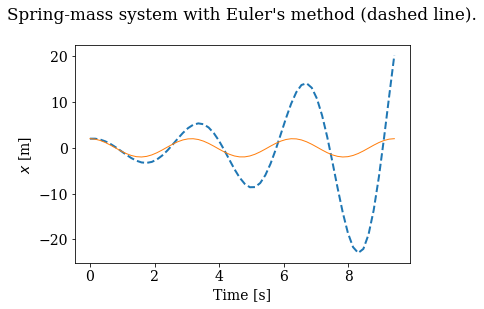

In [12]:
fig = pyplot.figure(figsize=(6,4))

pyplot.plot(t, num_sol[:, 0], linewidth=2, linestyle='--', label='Numerical solution')
pyplot.plot(t, x_an, linewidth=1, linestyle='-', label='Analytical solution')
pyplot.xlabel('Time [s]')
pyplot.ylabel('$x$ [m]')
pyplot.title('Spring-mass system with Euler\'s method (dashed line).\n');

Yikes! The numerical solution exhibits a marked growth in amplitude over time, which certainly is not what the physical system displays. _What is wrong with Euler's method?_

##### Exercise: 

* Try repeating the calculation above using smaller values of the time increment, `dt`, and see if the results improve. Try `dt=P/40`,  `P/160` and  `P/2000`.

* Although the last case, with 2000 steps per oscillation, does look good enough, see what happens if you then increase the time of simulation, for example to 20 periods. —Run the case again: _What do you see now?_

We consistently observe a growth in amplitude in the numerical solution, worsening over time. The solution does improve when we reduce the time increment `dt` (as it should), but the amplitude still displays unphysical growth for longer simulations.

## Euler-Cromer method

The thing is, Euler's method has a fundamental problem with oscillatory systems. Look again at the approximation made by Euler's method to get the position at the next time interval:

\begin{equation}
 x(t_i+\Delta t)   \approx  x(t_i) + v(t_i) \Delta t
\end{equation}

It uses the velocity value at the _beginning_ of the time interval to step the solution to the future. 

A graphical explanation can help here. Remember that the derivative of a function corresponds to the slope of the tangent at a point. Euler's method approximates the derivative using the slope at the initial point in an interval, and advances the numerical position with that initial velocity. The sketch below illustrates two consecutive Euler steps on a function with high curvature.

<img src="images/two-euler-steps.png" style="width: 500px;"/> 
#### Sketch of two Euler steps on a curved function.

Since Euler's method makes a linear approximation to project the solution into the future, assuming the value of the derivative at the start of the interval, it's not very good on oscillatory functions.

A clever idea that improves on Euler's method is to use the updated value of the derivatives for the _second_ equation.

Pure Euler's method applies:

\begin{eqnarray}
x(t_0) = x_0, \qquad x_{i+1} &=& x_i + v_i \Delta t \nonumber\\
v(t_0) = v_0, \qquad v_{i+1} &=& v_i - {\omega}^2 x_i \Delta t
\end{eqnarray}

What if in the equation for $v$ we used the value $x_{i+1}$ that was just computed? Like this:

\begin{eqnarray}
x(t_0) = x_0, \qquad x_{i+1} &=& x_i + v_i \Delta t \nonumber\\
v(t_0) = v_0, \qquad v_{i+1} &=& v_i - {\omega}^2 x_{i+1} \Delta t
\end{eqnarray}

Notice the $x_{i+1}$ on the right-hand side of the second equation: that's the updated value, giving the acceleration at the _end_ of the time interval. This modified scheme is called Euler-Cromer method, to honor clever Mr Cromer, who came up with the idea [2].

Let's see what it does. Study the function below carefully—it helps a lot if you write things out on a piece of paper!

In [13]:
def euler_cromer(state, rhs, dt):
    '''Update a state to the next time increment using Euler-Cromer's method.
    
    Arguments
    ---------
    state : array of dependent variables
    rhs   : function that computes the RHS of the DiffEq
    dt    : float, time increment
    
    Returns
    -------
    next_state : array, updated after one time increment'''
    
    mid_state = state + rhs(state)*dt # Euler step
    mid_derivs = rhs(mid_state)       # updated derivatives
    
    next_state = numpy.array([mid_state[0], state[1] + mid_derivs[1]*dt])
    
    return next_state

We've copied the whole problem set-up below, to get the solution in one code cell, for easy trial with different parameter choices. Try it out!

In [14]:
ω = 2
period = 2*numpy.pi/ω
dt = period/200  # time intervals per period 
T = 800*period   # simulation time, in number of periods
N = round(T/dt)

print('The number of time steps is {}.'.format( N ))
print('The time increment is {}'.format( dt ))

# time array
t = numpy.linspace(0, T, N)

x0 = 2    # initial position
v0 = 0    # initial velocity

#initialize solution array
num_sol = numpy.zeros([N,2])

#Set intial conditions
num_sol[0,0] = x0
num_sol[0,1] = v0

for i in range(N-1):
    num_sol[i+1] = euler_cromer(num_sol[i], springmass, dt)

The number of time steps is 160000.
The time increment is 0.015707963267948967


Recompute the analytical solution, and plot it alongside the numerical one, when you're ready. We computed a crazy number of oscillations, so we'll need to pick carefully the range of time to plot.

First, get the analytical solution. We chose to then plot the first few periods of the oscillatory motion: numerical and analytical.

In [15]:
x_an = x0*numpy.cos(ω * t) # analytical solution

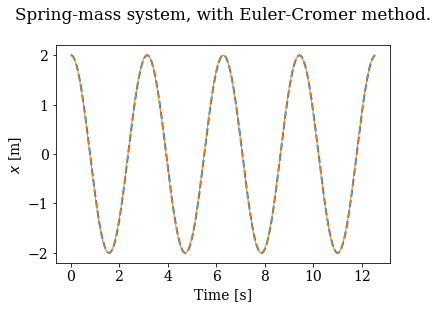

In [16]:
iend = 800 # in number of time steps

fig = pyplot.figure(figsize=(6,4))

pyplot.plot(t[:iend], num_sol[:iend, 0], linewidth=2, linestyle='--', label='Numerical solution')
pyplot.plot(t[:iend], x_an[:iend], linewidth=1, linestyle='-', label='Analytical solution')
pyplot.xlabel('Time [s]')
pyplot.ylabel('$x$ [m]')
pyplot.title('Spring-mass system, with Euler-Cromer method.\n');

The plot shows that Euler-Cromer does not have the problem of growing amplitudes. We're pretty happy with it in that sense.

But if we plot the end of a long period of simulation, you can see that it does start to  deviate from the analytical solution.

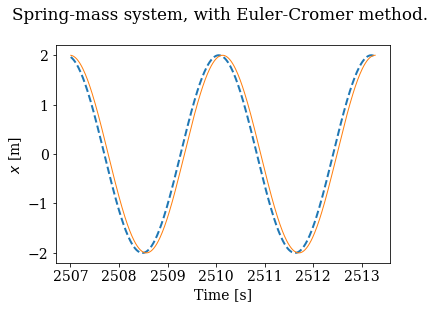

In [17]:
istart = 400

fig = pyplot.figure(figsize=(6,4))

pyplot.plot(t[-istart:], num_sol[-istart:, 0], linewidth=2, linestyle='--', label='Numerical solution')
pyplot.plot(t[-istart:], x_an[-istart:], linewidth=1, linestyle='-', label='Analytical solution')
pyplot.xlabel('Time [s]')
pyplot.ylabel('$x$ [m]')
pyplot.title('Spring-mass system, with Euler-Cromer method. \n');

Looking at the last few oscillations in a very long run shows a slight phase difference, even with a very small time increment. So although the Euler-Cromer method fixes a big problem with Euler's method, it still has some error. It's still a first-order method!

#### The Euler-Cromer method is first-order accurate, just like Euler's method. The global error is proportional to $\Delta t$.

##### Note:

You'll often find the presentation of the Euler-Cromer method with the reverse order of the equations, i.e., the velocity equation solved first, then the position equation solved with the updated value of the velocity. This makes no difference in the results: it's just a convention among physicists.

The Euler-Cromer method is equivalent to a [_semi-implicit Euler method_](https://en.wikipedia.org/wiki/Semi-implicit_Euler_method).

## Convergence

We've said that both Euler's method and the Cromer variant are _first-order accurate_: the error goes as the first power of $\Delta t$. In [Lesson 2](http://go.gwu.edu/engcomp3lesson2) of this module, we showed this using a Taylor series. Let's now confirm it numerically.

Because simple harmonic motion has a known analytical function that solves the differential equation, we can directly compute a measure of the error made by the numerical solution. 

Suppose we ran a numerical solution in the interval from $t_0$ to $T=N/\Delta t$. We could then compute the error, as follows:

\begin{equation}
e = x_N - x_0 \cos(\omega T)
\end{equation}

where $x_N$ represents the numerical solution at the $N$-th time step.

How could we confirm the order of convergence of a numerical method? In the lucky scenario of having an analytical solution to directly compute the error, all we need to do is solve numerically with different values of $\Delta t$ and see if the error really varies linearly with this parameter.

In the code cell below, we compute the numerical solution with different time increments. We use two nested `for`-statements: one iterates over the values of $\Delta t$, and the other iterates over the time steps from the initial condition to the final time. We save the results in a new variable called `num_sol_time`, which is an array of arrays. Check it out!


In [18]:
dt_values = numpy.array([period/50, period/100, period/200, period/400])
T = 1*period

num_sol_time = numpy.empty_like(dt_values, dtype=numpy.ndarray)


for j, dt in enumerate(dt_values):

    N = int(T/dt)
    t = numpy.linspace(0, T, N)
    
    #initialize solution array
    num_sol = numpy.zeros([N,2])
    
    
    #Set intial conditions
    num_sol[0,0] = x0
    num_sol[0,1] = v0
    
    for i in range(N-1):
        num_sol[i+1] = eulerstep(num_sol[i], springmass, dt)

    num_sol_time[j] = num_sol.copy()

We will need to compute the error with our chosen norm, so let's write a function for that. It includes a line to obtain the values of the analytical solution at the needed instant of time, and then it takes the difference with the numerical solution to compute the error.

In [19]:
def get_error(num_sol, T):
    
    x_an = x0 * numpy.cos(ω * T) # analytical solution at final time
    
    error =  numpy.abs(num_sol[-1,0] - x_an)
    
    return error

All that is left to do is to call the error function with our chosen values of $\Delta t$, and plot the results. A logarithmic scale on the plot confirms close to linear scaling between error and time increment.

In [20]:
error_values = numpy.empty_like(dt_values)

for j in range(len(dt_values)):
    
    error_values[j] = get_error(num_sol_time[j], T)

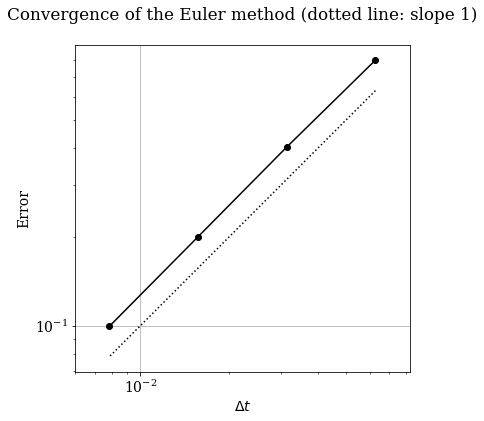

In [21]:
fig = pyplot.figure(figsize=(6,6))

pyplot.loglog(dt_values, error_values, 'ko-')  #log-log plot
pyplot.loglog(dt_values, 10*dt_values, 'k:')
pyplot.grid(True)                         #turn on grid lines
pyplot.axis('equal')                      #make axes scale equally
pyplot.xlabel('$\Delta t$')
pyplot.ylabel('Error')
pyplot.title('Convergence of the Euler method (dotted line: slope 1)\n');

What do you see in the plot of the error as a function of $\Delta t$? It looks like a straight line, with a slope close to 1. On a log-log convergence plot, a slope of 1 indicates that we have a first-order method: the error scales as ${\mathcal O}(\Delta t)$—using the "big-O" notation. It means that the error is proportional to the time increment: $ e \propto \Delta t.$

## Modified Euler's method

Another improvement on Euler's method is achieved by stepping the numerical solution to the midpoint of a time interval, computing the derivatives there, and then going back and updating the system state using the midpoint derivatives. This is called _modified Euler's method_.

If we write the vector form of the differential equation as: 

\begin{equation}
\dot{\mathbf{x}} = f(\mathbf{x}),
\end{equation}

then modified Euler's method is:
\begin{align}
\mathbf{x}_{n+1/2}   & = \mathbf{x}_n + \frac{\Delta t}{2} f(\mathbf{x}_n) \\
\mathbf{x}_{n+1} & = \mathbf{x}_n + \Delta t \,\, f(\mathbf{x}_{n+1/2}).
\end{align}

Let's see how it performs with our spring-mass model.

In [22]:
def rk2_step(state, rhs, dt):
    '''Update a state to the next time increment using modified Euler's method.
    
    Arguments
    ---------
    state : array of dependent variables
    rhs   : function that computes the RHS of the DiffEq
    dt    : float, time increment
    
    Returns
    -------
    next_state : array, updated after one time increment'''
    
    mid_state = state + rhs(state) * dt*0.5    
    next_state = state + rhs(mid_state)*dt
 
    return next_state

In [23]:
dt_values = numpy.array([period/50, period/100, period/200,period/400])
T = 1*period

num_sol_time = numpy.empty_like(dt_values, dtype=numpy.ndarray)


for j, dt in enumerate(dt_values):

    N = int(T/dt)
    t = numpy.linspace(0, T, N)
    
    #initialize solution array
    num_sol = numpy.zeros([N,2])
    
    
    #Set intial conditions
    num_sol[0,0] = x0
    num_sol[0,1] = v0
    
    for i in range(N-1):
        num_sol[i+1] = rk2_step(num_sol[i], springmass, dt)

    num_sol_time[j] = num_sol.copy()

In [24]:
error_values = numpy.empty_like(dt_values)

for j, dt in enumerate(dt_values):
    
    error_values[j] = get_error(num_sol_time[j], dt)

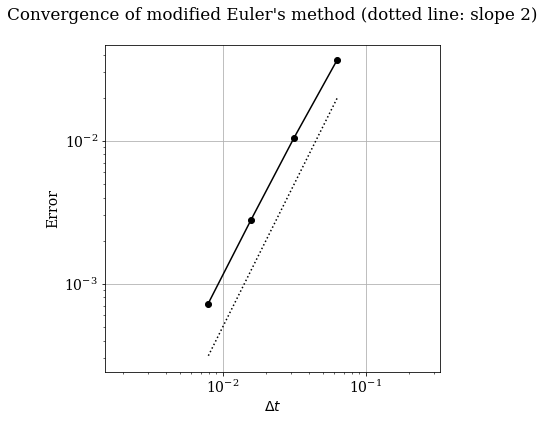

In [25]:
fig = pyplot.figure(figsize=(6,6))

pyplot.loglog(dt_values, error_values, 'ko-')
pyplot.loglog(dt_values, 5*dt_values**2, 'k:')
pyplot.grid(True)
pyplot.axis('equal')
pyplot.xlabel('$\Delta t$')
pyplot.ylabel('Error')
pyplot.title('Convergence of modified Euler\'s method (dotted line: slope 2)\n');

The convergence plot, in this case, does look close to a slope-2 line. Modified Euler's method is second-order accurate: 
the effect of computing the derivatives (slope) at the midpoint of the time interval, instead of the starting point, is to increase the accuracy by one order!

Using the derivatives at the midpoint of the time interval is equivalent to using the average of the derivatives at $t$ and $t+\Delta t$: 
this corresponds to a second-order _Runge-Kutta method_, or RK2, for short.
Combining derivatives evaluated at different points in the time interval is the key to Runge-Kutta methods that achieve higher orders of accuracy.

## What we've learned

* vector form of the spring-mass differential equation
* Euler's method produces unphysical amplitude growth in oscillatory systems
* the Euler-Cromer method fixes the amplitude growth (while still being first order)
* Euler-Cromer does show a phase lag after a long simulation
* a convergence plot confirms the first-order accuracy of Euler's method
* a convergence plot shows that modified Euler's method, using the derivatives evaluated at the midpoint of the time interval, is a second-order method

## References

1. Linge S., Langtangen H.P. (2016) Solving Ordinary Differential Equations. In: Programming for Computations - Python. Texts in Computational Science and Engineering, vol 15. Springer, Cham, https://doi.org/10.1007/978-3-319-32428-9_4, open access and reusable under [CC-BY-NC](http://creativecommons.org/licenses/by-nc/4.0/) license.

2. Cromer, A. (1981). Stable solutions using the Euler approximation. _American Journal of Physics_, 49(5), 455-459. https://doi.org/10.1119/1.12478


In [26]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../../style/custom.css'
HTML(open(css_file, "r").read())